<a href="https://colab.research.google.com/github/iceboxi/Colaboratory/blob/master/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 手寫數字分類
source: 
* https://www.kaggle.com/c/digit-recognizer/overview

## 下載資料

In [0]:
#Set the enviroment variables


 76% 56.0M/73.2M [00:00<00:00, 146MB/s]
100% 73.2M/73.2M [00:00<00:00, 162MB/s]
 82% 40.0M/48.8M [00:00<00:00, 98.2MB/s]
100% 48.8M/48.8M [00:00<00:00, 123MB/s] 
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 70.1MB/s]


## import

In [0]:
# Imports for Deep Learning
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

# ensure consistency across runs
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# Imports to view data
import cv2
from glob import glob

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
% matplotlib inline

import os, shutil
from os import listdir
from numpy import floor
import random
import numpy as np
import pandas as pd

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import train_test_split

## 讀取資料

In [0]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
submit = pd.read_csv('./sample_submission.csv')

In [0]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 查看data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



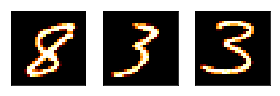

In [0]:
def plot_three_samples():
    plt.figure(figsize=(4,4))
    imgs = [random.randint(0, np.size(train, 0)) for _ in range(0, 3)]
    
    for digit_num in range(0,3):
        plt.subplot(1,3,digit_num+1)
        grid_data = train.iloc[imgs[digit_num],1:].as_matrix().reshape(28,28)  # reshape from 1d to 2d pixel array
        plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout()
    return

plot_three_samples()

## 設定常數

In [0]:
target_dims = (28, 28, 1)
n_classes = 10
batch_size = 64
val_frac = 0.1
seed = 42
epochs = 3

## 分割訓練與測試集

In [0]:
train_data = train.iloc[:,1:]
target = train.iloc[:,0]

In [0]:
target = to_categorical(target, num_classes=n_classes) # one-hot，不一定需要

### 使用後差異會在兩個地方，一個是分割測試來源時，target不取valurs，
### model的 loss 改用 categorical_crossentropy 而不是 sparse_categorical_crossentropy

In [0]:
X_train , X_test , y_train , y_test = train_test_split(train_data.values , target , test_size = 0.1, random_state = seed) 

In [0]:
X_train = X_train.reshape(-1 , 28 , 28 , 1)/255
X_test = X_test.reshape(-1 , 28 , 28 , 1)/255

In [0]:
print(X_train.shape, y_train.shape, test.shape)

(35700, 28, 28, 1) (35700, 10) (28000, 784)


### 定義model

In [0]:
def cnn_model1():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = target_dims))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size = (2,2), padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation = "softmax"))
    return model

In [0]:
def cnn_model2():
    model = Sequential()
    model.add(Conv2D(filters = 16 , kernel_size= (3,3) , activation= 'relu' , input_shape = (28 , 28 ,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters= 16 , kernel_size= (3,3) , activation= 'relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters= 16 , kernel_size= (3,3) , activation= 'relu' ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

In [0]:
model = cnn_model1()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# model.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer=Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
# model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
__________

## 設定data generator

In [0]:
# datagen = ImageDataGenerator(zoom_range = 0.1,
#                             height_shift_range = 0.1,
#                             width_shift_range = 0.1,
#                             rotation_range = 10)

datagen = ImageDataGenerator(
                              featurewise_center = False,  # set input mean to 0 over the dataset
                              samplewise_center = False,  # set each sample mean to 0
                              featurewise_std_normalization = False,  # divide inputs by std of the dataset
                              samplewise_std_normalization = False,  # divide each input by its std
                              zca_whitening = False,  # apply ZCA whitening
                              rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
                              zoom_range = 0.1, # Randomly zoom image 
                              width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
                              height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
                              horizontal_flip = False,  # randomly flip images
                              vertical_flip = False, # randomly flip images
                              validation_split = val_frac
                            )

## 設定 callback

In [0]:
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## 訓練

In [0]:
# history = model.fit_generator(datagen.flow(X_train , y_train , batch_size=16) ,
#                               steps_per_epoch = 500,
#                               epochs = epochs,
#                               verbose = 1,
#                               callbacks=[learning_rate_reduction]
#                              )

history = model.fit_generator(datagen.flow(X_train , y_train , batch_size = batch_size) ,
                              steps_per_epoch = X_train.shape[0],
                              validation_data = (X_test, y_test), # 訓練同時測試
                              epochs = epochs,
                              verbose = 1,
                              callbacks=[learning_rate_reduction]
                             )

Epoch 1/50
558/558 [==============================] - 83s 148ms/step - loss: 0.1433 - acc: 0.9557 - val_loss: 0.0393 - val_acc: 0.9871
Epoch 2/50
558/558 [==============================] - 83s 150ms/step - loss: 0.1261 - acc: 0.9610 - val_loss: 0.0339 - val_acc: 0.9898
Epoch 3/50
558/558 [==============================] - 81s 146ms/step - loss: 0.1177 - acc: 0.9639 - val_loss: 0.0321 - val_acc: 0.9887
Epoch 4/50
558/558 [==============================] - 84s 150ms/step - loss: 0.1065 - acc: 0.9671 - val_loss: 0.0311 - val_acc: 0.9902
Epoch 5/50
558/558 [==============================] - 83s 148ms/step - loss: 0.1088 - acc: 0.9674 - val_loss: 0.0328 - val_acc: 0.9890
Epoch 6/50
558/558 [==============================] - 83s 148ms/step - loss: 0.0990 - acc: 0.9694 - val_loss: 0.0296 - val_acc: 0.9903
Epoch 7/50
558/558 [==============================] - 83s 148ms/step - loss: 0.1009 - acc: 0.9708 - val_loss: 0.0302 - val_acc: 0.9906
Epoch 8/50
558/558 [==============================] - 8

In [0]:
final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0) # 其他測試方式
print('loss =' , final_loss , '\naccuracy' , final_acc)

loss = 0.022507559460528206 
accuracy 0.9915873


In [0]:
model.save_weights("model.h5")

## 圖形化訓練結果

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

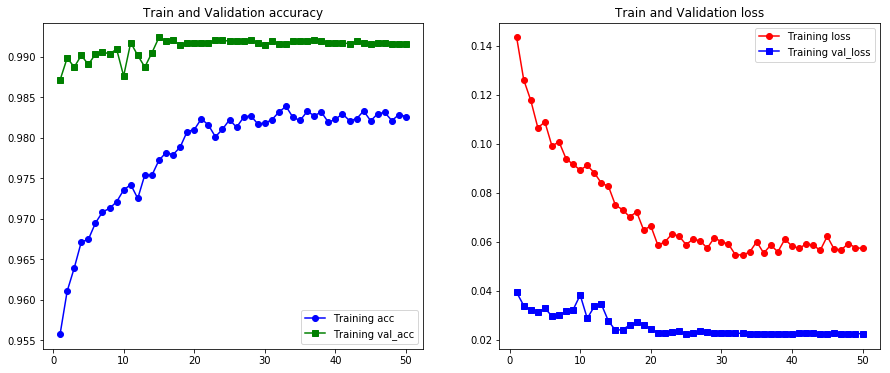

In [0]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'gs-', label='Training val_acc')
plt.title('Train and Validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro-', label='Training loss')
plt.plot(epochs, val_loss, 'bs-', label='Training val_loss')
plt.title('Train and Validation loss')
plt.legend()

## 預測與準備上傳檔案

In [0]:
test = test.values
test = test.reshape(-1 , 28 , 28 ,1)/255
pre = model.predict(test, batch_size=64)

In [0]:
pre = np.argmax(pre , axis = 1)

In [0]:
pre

array([2, 0, 9, ..., 3, 9, 2])

In [0]:
submit.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [0]:
submit['Label'] = pre

In [0]:
submit.to_csv('submit.csv' , index= False)